# Deep Learning for Computer Vision:  Final Project

## Computer Science: COMS W 4995 006

#### Author: Carmem Domingues

### Problem: Distinguishing between underwater ocean images containing plastic and not

Plastic Pollution in our waterways (rivers, lakes, oceans, etc.) is a huge environmental problem in today's world. It is predicted that by 2050 there will be more plastic (by weight) than fish in the ocean. 

I would like to use Deep Learning and Computer Vision to help solve this problem. The applications of this are many, but we start with the simple problem of using DL and CV to distinguish between underwater ocean images that contain pieces of plastic, and those that do not (and only contain normal marine life). 

Data was collected manually via Google Searches. More information on the data collection process can be found on the Final Presentation and Final Report for this project.

For the analysis:

1. Start with a simple ConvNet, to help us distinguish between plastic and no-plastic images
2. Use a ConvNet (VGG16) that was pre-trained on ImageNet to see how we do
3. Modify the top layers for the binary case, freeze all layers up to the top, and retrain just the top ones 
4. Unfreeze all layers and continue fine tuning
5. Try ResNet, using similar process as steps 3-4
6. If time allows, we move on to object detection within the images, to try and identify which parts of the images are plastic vs. normal marine life

Note: Steps 1-4 are inspired and leverage code from homework 5.

In [1]:
import os
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers

%matplotlib inline

/Users/carmem/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Setup some basics for the models:

In [3]:
nb_classes = 2
class_name = {
    0: 'noplastic',
    1: 'plastic',
}

In [10]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '../Images/data_for_modeling/train'
validation_data_dir = '../Images/data_for_modeling/validation'
nb_train_samples = 900+700
nb_validation_samples = 77+70
batch_size = 32
steps_per_epoch_train = nb_train_samples / batch_size
steps_per_epoch_val = nb_validation_samples / batch_size

Use the code from homework 5 for showing the images:

In [5]:
def show_sample(X, y, prediction=-1):
    im = X
    plt.imshow(im)
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
    else:
        plt.title("Class = %s" % (class_name[y]))

    plt.axis('on')
    plt.show()

In [25]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 1586 images belonging to 2 classes.
Found 147 images belonging to 2 classes.


In [12]:
nb_train_samples, nb_validation_samples

(1600, 147)

##### Looks like images were "lost" for some reason -> from 1600 training images, it only picked up 1587

Show some sample images from the dataset - borrow code from homework 5

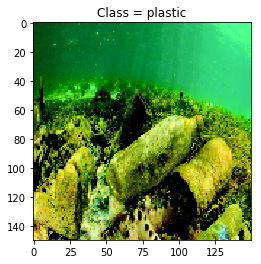

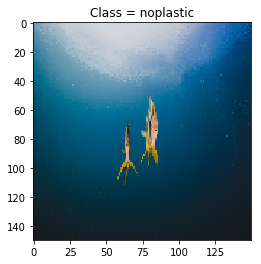

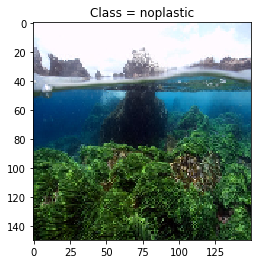

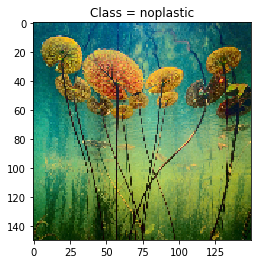

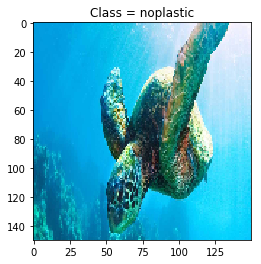

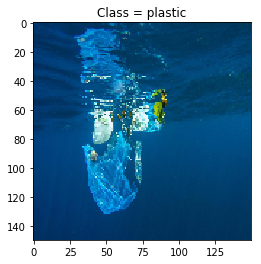

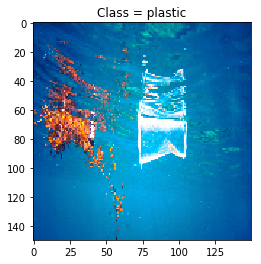

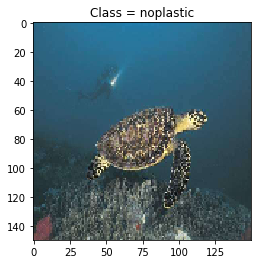

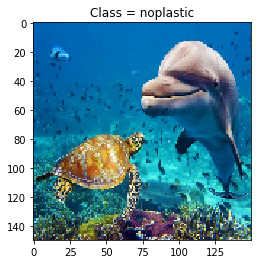

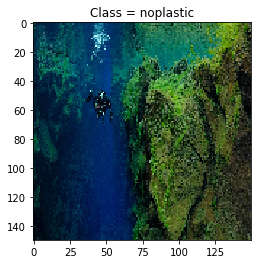

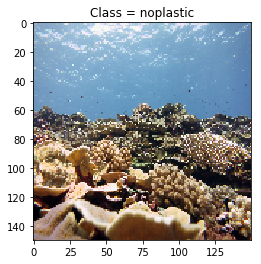

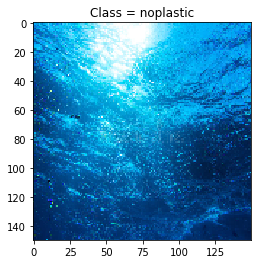

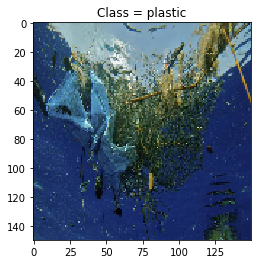

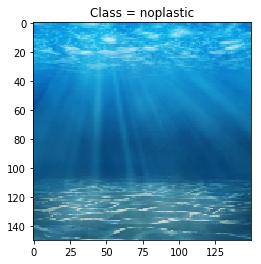

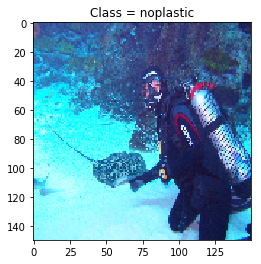

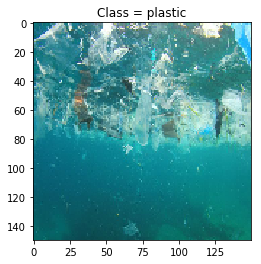

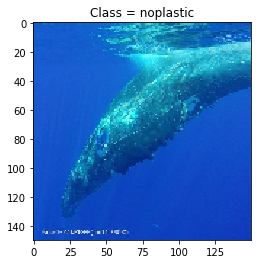

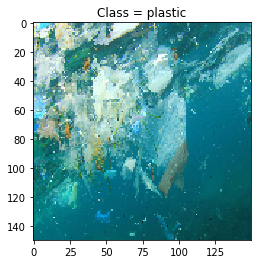

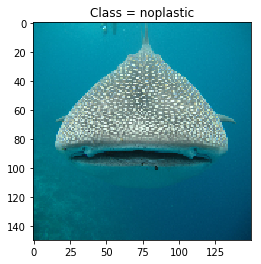

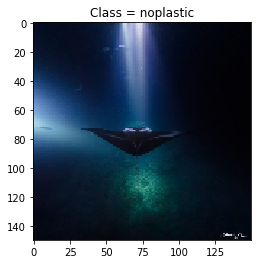

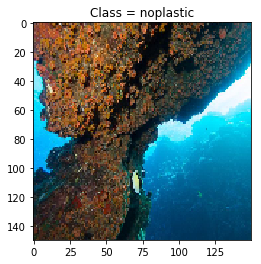

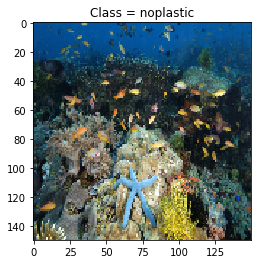

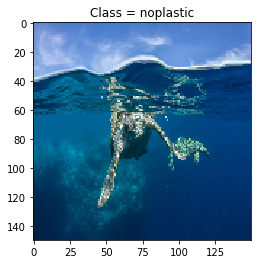

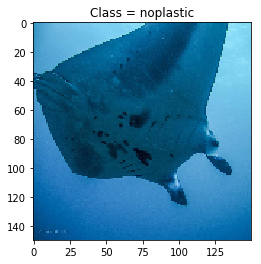

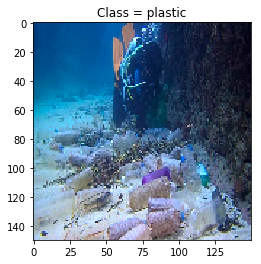

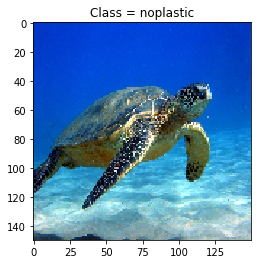

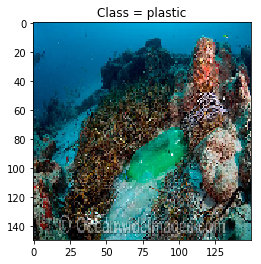

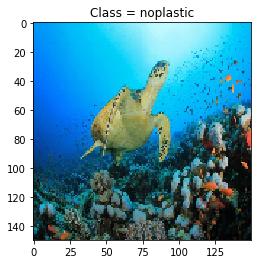

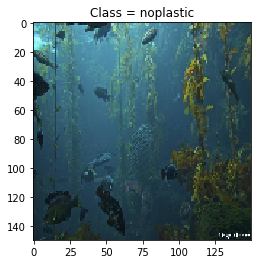

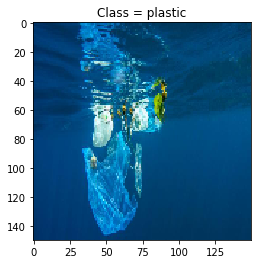

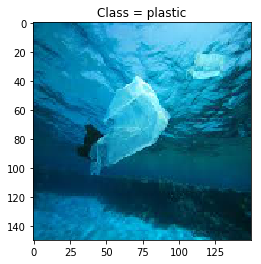

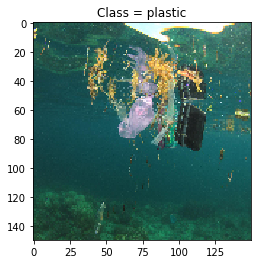

In [13]:
for X_batch, Y_batch in validation_generator:
    for i in range(len(Y_batch)):
        show_sample(X_batch[i, :, :, :], Y_batch[i])
    break

## 1. Simple ConvNet (from homework 5) 

In [20]:
model_scn = Sequential()
model_scn.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model_scn.add(Activation('relu'))
model_scn.add(MaxPooling2D(pool_size=(2, 2)))

model_scn.add(Conv2D(32, (3, 3)))
model_scn.add(Activation('relu'))
model_scn.add(MaxPooling2D(pool_size=(2, 2)))

model_scn.add(Conv2D(63, (3, 3)))
model_scn.add(Activation('relu'))
model_scn.add(MaxPooling2D(pool_size=(2, 2)))

model_scn.add(Flatten())
model_scn.add(Dense(64))
model_scn.add(Activation('relu'))
model_scn.add(Dropout(0.5))
model_scn.add(Dense(1))
model_scn.add(Activation('sigmoid'))

In [21]:
model_scn.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

print(model_scn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 63)        18207     
__________

In [22]:
%pushd
%mkdir -p history
%mkdir -p models
%mkdir -p logs
%cd logs 
%mkdir -p ./scn
%mkdir -p ./vgg16_fine_tuning
%popd

/Users/carmem/Documents/Columbia/DL4CV/Project/dl_4_cv/logs
/Users/carmem/Documents/Columbia/DL4CV/Project/dl_4_cv
popd -> ~/Documents/Columbia/DL4CV/Project/dl_4_cv


In [23]:
tensorboard_callback_scn = TensorBoard(log_dir='./logs/scn/', 
                                       histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback_scn = ModelCheckpoint('./models/scn_weights.{epoch:02d}-{val_acc:.2f}.hdf5', 
                                          monitor='val_acc', verbose=0, save_best_only=True, 
                                          save_weights_only=False, mode='auto', period=1)

Train the model

In [27]:
%%time
nb_epoch_scn = 10

hist_scn = model_scn.fit_generator(train_generator, 
              initial_epoch=0, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epoch_scn, 
              callbacks=[tensorboard_callback_scn, checkpoint_callback_scn],
              validation_steps=steps_per_epoch_val)
                                                                                                                                   
pandas.DataFrame(hist_scn.history).to_csv("./history/scn.csv")

Epoch 1/10
50/50 [==============================] - 71s 1s/step - loss: 0.5087 - acc: 0.7449 - val_loss: 0.5684 - val_acc: 0.7007
Epoch 2/10
50/50 [==============================] - 65s 1s/step - loss: 0.5220 - acc: 0.7349 - val_loss: 0.5667 - val_acc: 0.7211
Epoch 3/10
50/50 [==============================] - 65s 1s/step - loss: 0.4907 - acc: 0.7618 - val_loss: 0.7939 - val_acc: 0.6667
Epoch 4/10
50/50 [==============================] - 66s 1s/step - loss: 0.4965 - acc: 0.7699 - val_loss: 0.6306 - val_acc: 0.7211
Epoch 5/10
50/50 [==============================] - 66s 1s/step - loss: 0.4866 - acc: 0.7682 - val_loss: 0.6728 - val_acc: 0.7007
Epoch 6/10
50/50 [==============================] - 66s 1s/step - loss: 0.4730 - acc: 0.7810 - val_loss: 0.7836 - val_acc: 0.7007
Epoch 7/10
50/50 [==============================] - 66s 1s/step - loss: 0.4621 - acc: 0.7882 - val_loss: 0.5440 - val_acc: 0.7347
Epoch 8/10
50/50 [==============================] - 67s 1s/step - loss: 0.4432 - acc: 0.79

Grab some validation batches and evaluate our accuracy:

In [29]:
accuracies_scn = np.array([])
losses_scn = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = model_scn.evaluate(X_batch, Y_batch, verbose=0)
    losses_scn = np.append(losses, loss)
    accuracies_scn = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
       break
       
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies_scn), np.mean(losses_scn)))

Validation: accuracy = 0.812500  ;  loss = 0.469345


In [31]:
X_test, y_test = next(validation_generator)
predictions_scn = model_scn.predict_classes(X_test, batch_size=32, verbose=0)

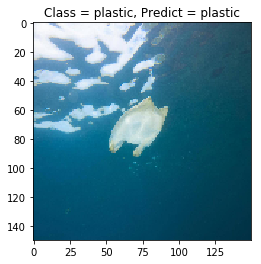

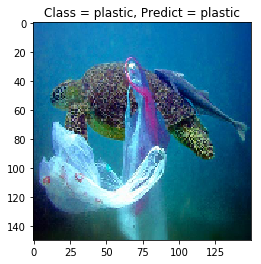

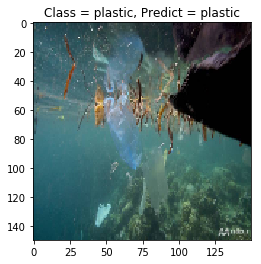

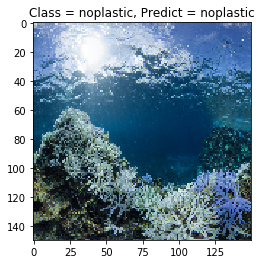

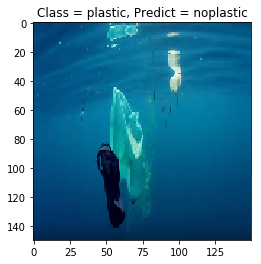

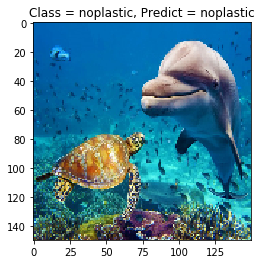

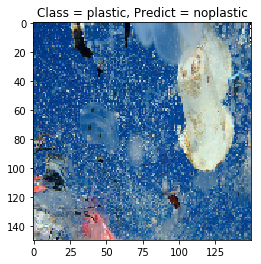

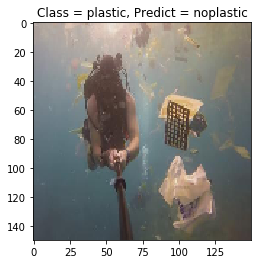

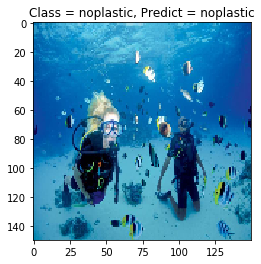

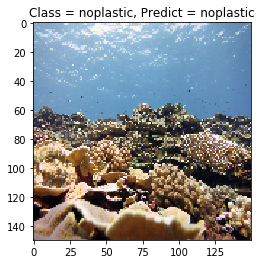

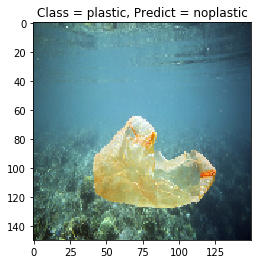

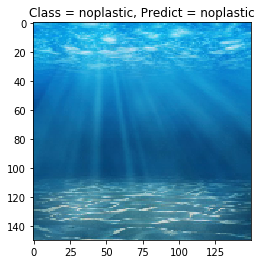

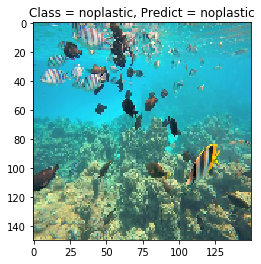

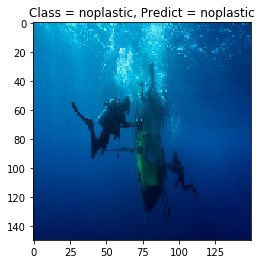

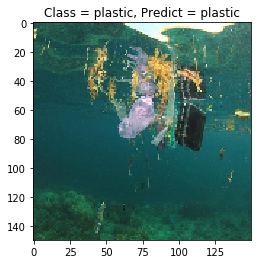

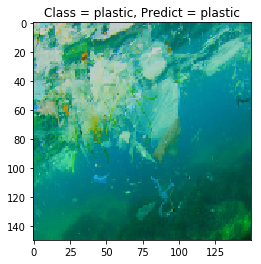

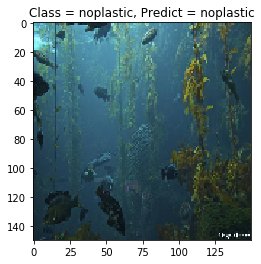

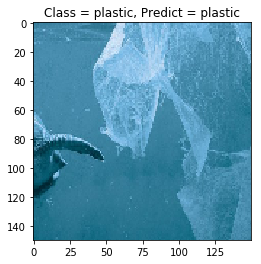

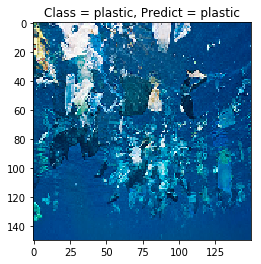

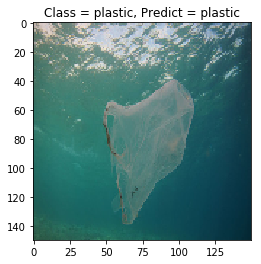

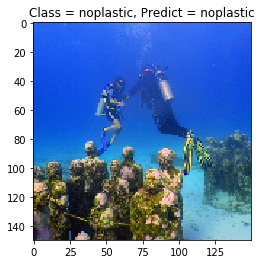

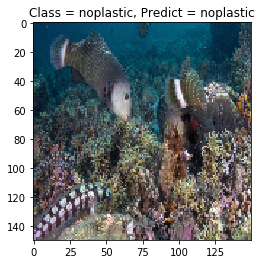

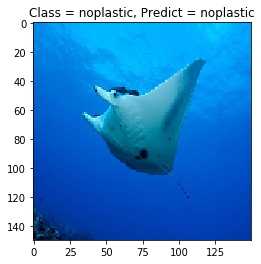

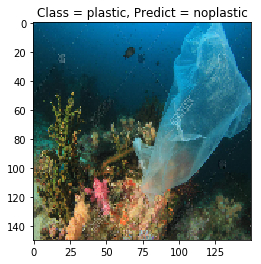

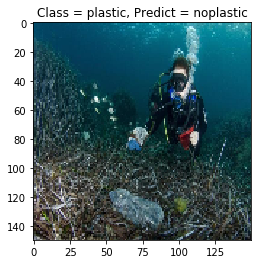

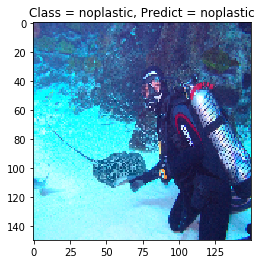

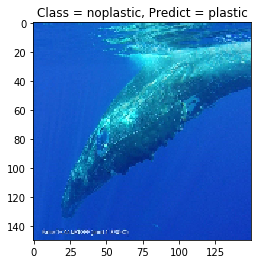

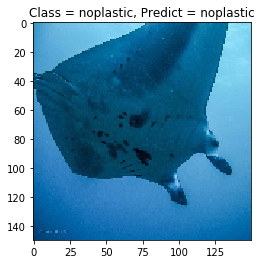

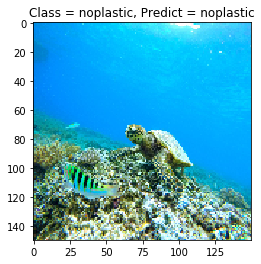

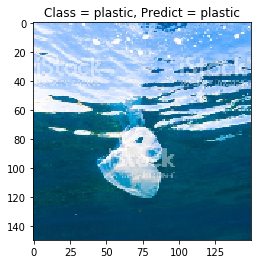

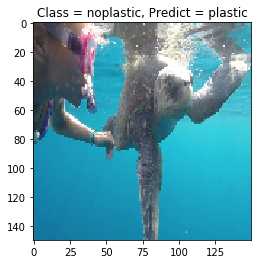

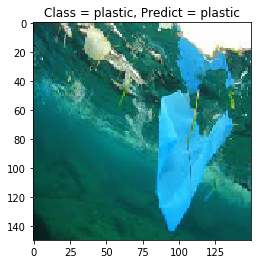

In [33]:
for i in range(32):
    show_sample(X_test[i, :, :, :], y_test[i], prediction=predictions_scn[i, 0])

Most of the mis-predictions were true label "plastic", but predicted "no plastic" -> seems like there is a bias in the model